In [ ]:
!pip install smdebug ipywidgets 
!pip install --upgrade sagemaker 



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
#import library 
import boto3
import sagemaker 
from sagemaker import get_execution_role
import os , glob , tarfile , zipfile  , re
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms ,models
import cv2
%matplotlib inline 

In [ ]:
session = sagemaker.Session()
region_name = session.boto_region_name
role = get_execution_role()
default_bucket = session.default_bucket()
print(default_bucket)
print(region_name)

sagemaker-us-east-1-644236161621
us-east-1


In [ ]:
#download data
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip"
path_to_saved = "Weather-Dataset.zip"
print("Start downloading....")
urlretrieve(url, path_to_saved)
print("Data is installed.")

Start downloading....
Data is installed.


In [ ]:
with zipfile.ZipFile(path_to_saved) as f:
    f.extractall(".")
print("Files are extracted ")
print(os.listdir())

Files are extracted 
['.config', 'Weather-Dataset.zip', '.cache', '.ipynb_checkpoints', '.sagemaker-jumpstart-tasks-status.json', '.jupyter', '.ipython', '.aws', 'dataset2.zip', 'Untitled.ipynb', '.local', '.yarnrc']


In [ ]:
with zipfile.ZipFile("dataset2.zip") as f:
    f.extractall(".")
print("Data is extracted")
print(len(os.listdir("dataset2")))

Data is extracted
1125


In [ ]:
#extract label from data 
for file in os.listdir("dataset2/")[:10]:
    print(file)

sunrise125.jpg
cloudy269.jpg
rain205.jpg
rain16.jpg
shine118.jpg
rain124.jpg
sunrise206.jpg
cloudy188.jpg
sunrise80.jpg
shine190.jpg


In [ ]:
re.findall(r"([a-zA-Z]+)\d+\.j\w+g" , "rain24.jpg")

['rain']

In [ ]:
for file in os.listdir("dataset2/"):
    if "jpg" not in file:
        print("threre are files not images")
        print(file)

threre are files not images
rain24.jpeg
threre are files not images
rain22.jpeg
threre are files not images
sunrise89.jpeg


In [ ]:
labels =[]
for file in os.listdir("dataset2/"):
    label =re.findall(r"([a-zA-Z]+)\d+\.j\w+g" ,file)[0]
    labels.append(label)

In [ ]:
len(labels)

1125

In [ ]:
data = pd.DataFrame({"image":os.listdir("dataset2/") , "labels":labels})
data.head()

,image,labels
0,sunrise125.jpg,sunrise
1,cloudy269.jpg,cloudy
2,rain205.jpg,rain
3,rain16.jpg,rain
4,shine118.jpg,shine


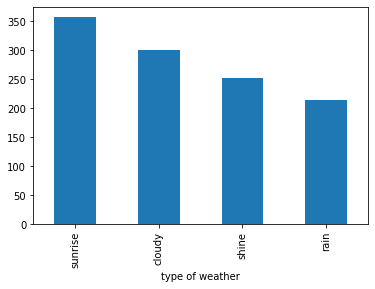

In [ ]:
data['labels'].value_counts().plot(kind = "bar")
plt.xlabel("type of weather")
plt.show()

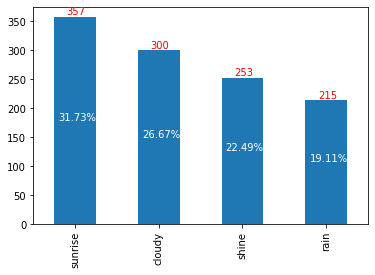

In [ ]:
ax = data['labels'].value_counts().plot(kind = "bar")
for p in ax.patches:
    x , y = p.get_xy()
    h , w = p.get_height() , p.get_width()
    plt.text(x+0.3*w , y+1.01*h , h , color="r")
    plt.text(x+0.1*w , y+0.5*h , f"{h/data.shape[0]*100:0.2f}%", color ="w")
plt.show()

In [ ]:
os.environ['DEFAULT_S3_BUCKET']=default_bucket

In [ ]:
#upload data
!aws s3 sync ./dataset2/ s3://${DEFAULT_S3_BUCKET}/Dataset

upload: dataset2/cloudy10.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy10.jpg
upload: dataset2/cloudy101.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy101.jpg
upload: dataset2/cloudy103.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy103.jpg
upload: dataset2/cloudy100.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy100.jpg
upload: dataset2/cloudy105.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy105.jpg
upload: dataset2/cloudy104.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy104.jpg
upload: dataset2/cloudy110.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy110.jpg
upload: dataset2/cloudy109.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy109.jpg
upload: dataset2/cloudy106.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy106.jpg
upload: dataset2/cloudy107.jpg to s3://sagemaker-us-east-1-644236161621/Dataset/cloudy107.jpg
upload: dataset2/cloudy111.jpg to s3://sagemaker-us-east-1-644

In [ ]:
#visulaize some data 
data_used = data.groupby("labels").sample(10)
data_used.sample(5)

,image,labels
4,shine118.jpg,shine
14,rain52.jpg,rain
136,rain195.jpg,rain
274,cloudy58.jpg,cloudy
622,cloudy279.jpg,cloudy


In [ ]:
data_used['labels'].unique().tolist()

['cloudy', 'rain', 'shine', 'sunrise']

In [ ]:
data_used.query(f"labels=='cloudy'")['image']

191     cloudy32.jpg
411     cloudy38.jpg
470     cloudy34.jpg
622    cloudy279.jpg
207    cloudy140.jpg
670    cloudy172.jpg
943    cloudy255.jpg
122    cloudy162.jpg
274     cloudy58.jpg
480     cloudy16.jpg
Name: image, dtype: object

In [ ]:
for i in ['cloudy', 'rain', 'shine', 'sunrise']:
    images = data_used.loc[data_used['labels']==i, "image"]
    print(images)

191     cloudy32.jpg
411     cloudy38.jpg
470     cloudy34.jpg
622    cloudy279.jpg
207    cloudy140.jpg
670    cloudy172.jpg
943    cloudy255.jpg
122    cloudy162.jpg
274     cloudy58.jpg
480     cloudy16.jpg
Name: image, dtype: object
120    rain177.jpg
673     rain79.jpg
763     rain84.jpg
318    rain108.jpg
786    rain130.jpg
760    rain192.jpg
136    rain195.jpg
561    rain203.jpg
180    rain137.jpg
14      rain52.jpg
Name: image, dtype: object
4       shine118.jpg
86      shine198.jpg
685      shine30.jpg
512      shine80.jpg
40      shine253.jpg
19       shine19.jpg
978     shine113.jpg
953     shine140.jpg
1116    shine234.jpg
738      shine78.jpg
Name: image, dtype: object
1098    sunrise223.jpg
733      sunrise67.jpg
185     sunrise291.jpg
1017    sunrise177.jpg
766     sunrise193.jpg
1059    sunrise214.jpg
912     sunrise119.jpg
296      sunrise46.jpg
916     sunrise317.jpg
1087     sunrise61.jpg
Name: image, dtype: object


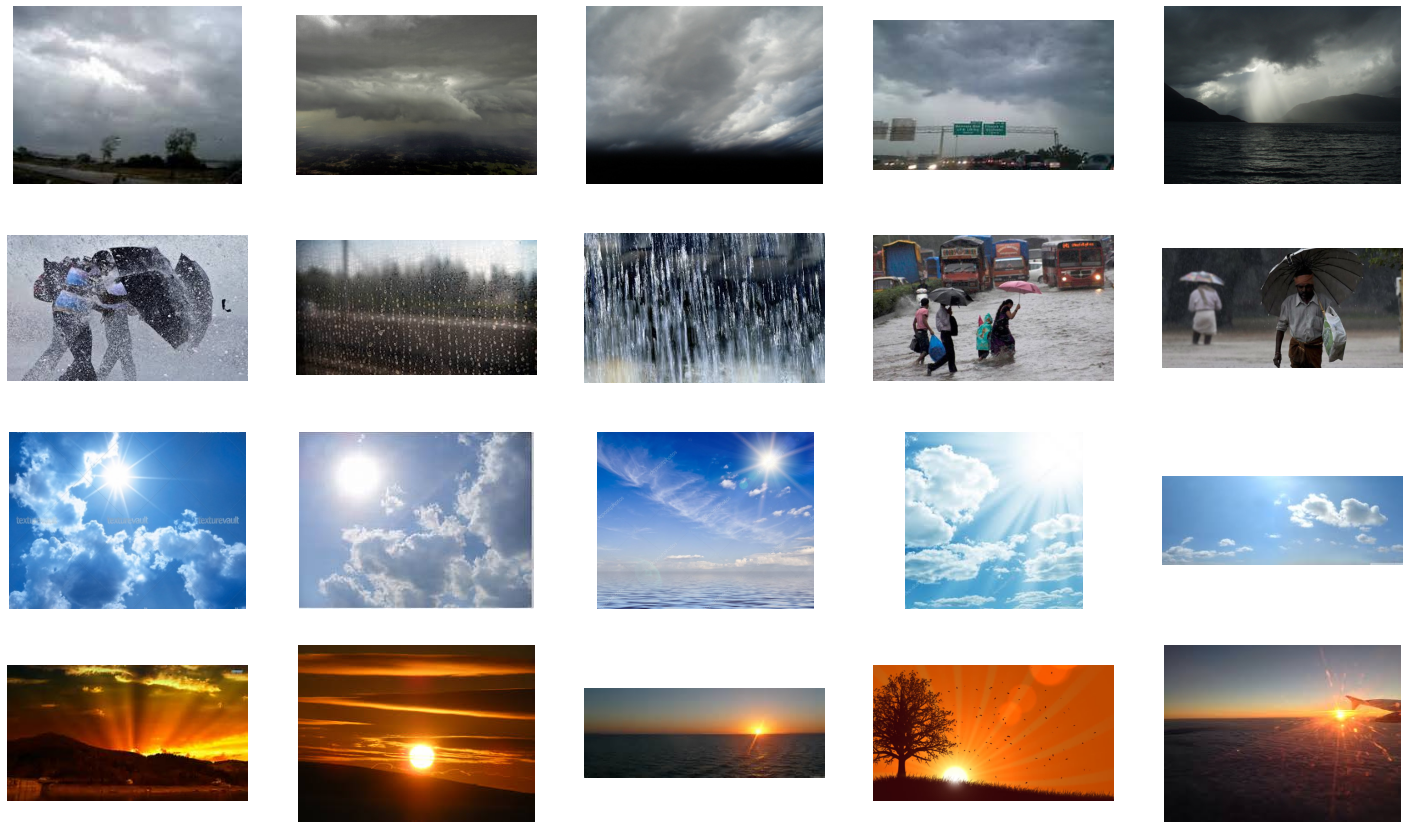

In [ ]:
fig , axes = plt.subplots(4 , 5 , figsize=(25, 15))
for label , plot_axes in zip(data_used['labels'].unique().tolist() , axes):
    images = data_used.loc[data_used['labels']==label , "image"].tolist()
    for i ,plot in enumerate(plot_axes):
        plot.imshow(plt.imread(os.path.join("dataset2", images[i])))
        plot.axis("off")
        plot.grid(False)

In [ ]:
def check_all_size_equal(path):
    images = os.listdir(path)
    size = plt.imread(os.path.join(path ,images[0])).shape
    for file in images[1:]:
        shape = plt.imread(os.path.join(path , file)).shape
        if shape != size:
            return False
    return True 

In [ ]:
check_all_size_equal("dataset2/")

False

In [ ]:
def get_average_size(path):
    avg_size =[0 , 0 ]
    images = os.listdir(path)
    for file in images:
        shape = plt.imread(os.path.join(path , file)).shape
        avg_size[0]+=shape[0]
        avg_size[1]+=shape[1]
    avg_size = [i/len(images) for i in avg_size]
    return avg_size

In [ ]:
avg_size = get_average_size("dataset2")

In [ ]:
avg_size

[334.75377777777777, 506.3031111111111]

In [ ]:
from sklearn.utils import compute_class_weight


In [ ]:
#run a base line for model that used in script mode before i write it
def get_model():
    model = models.resnet50(weights=models.resnet.ResNet50_Weights.IMAGENET1K_V2)
    for param in model.parameters():
        param.requires_grad = False 
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(
        nn.Linear(2048 , 1024),
        nn.ReLU(inplace=True) ,
        nn.BatchNorm1d(1024),
        nn.Dropout(0.6),
        nn.Linear(1024 ,4)
    )
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    return model , optimizer ,loss_fn

In [ ]:
model ,optimizer , loss_fn = get_model()


In [ ]:
labels = data['labels'].unique()

In [ ]:
dict(zip(labels.tolist(), range(4)))

{'sunrise': 0, 'cloudy': 1, 'rain': 2, 'shine': 3}

In [ ]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, path,transform):
        from random import shuffle , seed
        maps = dict(zip(labels.tolist(), range(4)))
        self.path = path
        self.images = os.listdir(path)
        self.labels = self._get_labels()
        self.transform  = transform
        self.labels = [maps[i] for i in self.labels]
        seed(42)
        shuffle(self.images)
        shuffle(self.labels)
        self.labels = torch.Tensor(self.labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self ,index):
        image_dir = os.path.join(self.path , self.images[index])
        image = plt.imread(image_dir).astype(np.uint8)
        '''
        try:
            image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        except:
            print(image)
            print(image_dir)
            print(image.shape)
            print(type(image))
        '''
        image = self.transform(image)
        return image ,self.labels[index]
    def _get_labels(self):
        labels =[]
        for file in os.listdir(self.path):
            label =re.findall(r"([a-zA-Z]+)\d+\.j\w+g" ,file)[0]
            labels.append(label)
        return labels
        
    
        

In [ ]:
models.resnet.ResNet50_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                                #transforms.RandomHorizontalFlip(p=(0.2 , 0.5)),
                                #transforms.RandomVerticalFlip(p=(0.2 , 0.5)),
                                #transforms.Resize((340 , 510)),
                                transforms.ToTensor(),
                                transforms.Resize((340 , 510)),
                                transforms.RandomCrop((340,510)),
                                transforms.Lambda(lambda x :x[:3]),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406] , 
                                                     std =[0.229, 0.224, 0.225])
                               ])


In [ ]:
data.shape

(1125, 2)

In [ ]:
#split data 
from sklearn.model_selection import train_test_split
train , valid = train_test_split(data , test_size=0.1 , shuffle=True , random_state=42 , stratify=data['labels'])
display(train.head())
display(valid.head())
print("trai size "  , train.shape)
print("valid size" , valid.shape)

,image,labels
650,rain152.jpg,rain
151,cloudy113.jpg,cloudy
873,rain109.jpg,rain
603,sunrise144.jpg,sunrise
1065,rain213.jpg,rain


,image,labels
592,rain71.jpg,rain
702,cloudy19.jpg,cloudy
1068,shine45.jpg,shine
937,sunrise210.jpg,sunrise
14,rain52.jpg,rain


trai size  (1012, 2)
valid size (113, 2)


Text(0.5, 1.0, 'valid data')

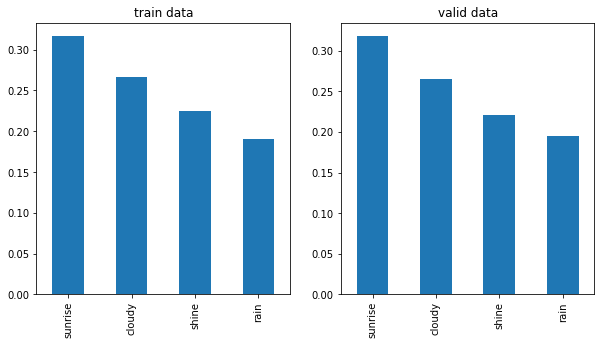

In [ ]:
plt.figure(figsize=(10 , 5))
plt.subplot(121)
train["labels"].value_counts(normalize=True).plot(kind ="bar")
plt.title("train data")
plt.subplot(122)
valid["labels"].value_counts(normalize=True).plot(kind="bar")
plt.title("valid data")

In [ ]:
import shutil
all_data = {"train" : train , "valid" : valid}
for data in ["train","valid"] : 
    os.mkdir(data)
    print(data + " file is created")
    for file in all_data[data]["image"].tolist():
        image_dir = os.path.join("dataset2" , file)
        shutil.move(image_dir , data)
    print("data is transfered totally")
        

train file is created
data is transfered totally
valid file is created
data is transfered totally


In [ ]:
!aws s3 sync ./valid s3://${DEFAULT_S3_BUCKET}/valid

upload: valid/cloudy101.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy101.jpg
upload: valid/cloudy102.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy102.jpg
upload: valid/cloudy118.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy118.jpg
upload: valid/cloudy14.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy14.jpg
upload: valid/cloudy103.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy103.jpg
upload: valid/cloudy161.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy161.jpg
upload: valid/cloudy176.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy176.jpg
upload: valid/cloudy157.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy157.jpg
upload: valid/cloudy186.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy186.jpg
upload: valid/cloudy170.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy170.jpg
upload: valid/cloudy145.jpg to s3://sagemaker-us-east-1-644236161621/valid/cloudy145.jpg
upload: valid/cloudy140

In [ ]:
def check_channel(path):
    res =[]
    for file in os.listdir(path):
        dim = plt.imread(os.path.join(path , file)).ndim
        res.append(dim)
    return res

In [ ]:
res = check_channel("train")

In [ ]:
set(res)

{2, 3}

In [ ]:
not_desired =[]
for file in os.listdir("train"):
    image_dir = os.path.join("train",file)
    dim = plt.imread(image_dir).ndim
    if dim!=3:
        not_desired.append(image_dir)
    

In [ ]:
not_desired

['train/cloudy66.jpg', 'train/cloudy71.jpg']

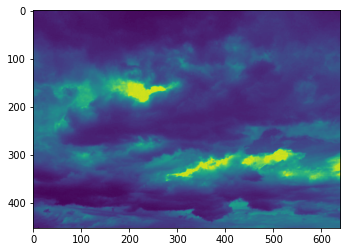

In [ ]:
plt.imshow(plt.imread(not_desired[0]))

In [ ]:
for file in not_desired:
    os.remove(file)

In [ ]:
not_desired =[]
for file in os.listdir("valid"):
    image_dir = os.path.join("valid",file)
    dim = plt.imread(image_dir).ndim
    if dim!=3:
        not_desired.append(image_dir)
    

In [ ]:
not_desired

[]

In [ ]:
train_set = DataSet("train" , transform)
valid_set = DataSet("valid" , transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set , batch_size=32 , shuffle=True )
valid_loader = torch.utils.data.DataLoader(valid_set , batch_size=64 )


In [ ]:
for x , y in train_loader:
    print(x.shape)
    print(y.shape)

torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([32, 3, 340, 510])
torch.Size([32])
torch.Size([3

In [ ]:
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train

upload: train/cloudy1.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy1.jpg 
upload: train/cloudy100.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy100.jpg
upload: train/cloudy107.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy107.jpg
upload: train/cloudy105.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy105.jpg
upload: train/cloudy111.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy111.jpg
upload: train/cloudy112.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy112.jpg
upload: train/cloudy113.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy113.jpg
upload: train/cloudy108.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy108.jpg
upload: train/cloudy109.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy109.jpg
upload: train/cloudy114.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy114.jpg
upload: train/cloudy115.jpg to s3://sagemaker-us-east-1-644236161621/train/cloudy115.jpg
upload: train/cloudy106.

In [ ]:
model(x).argmax(dim=1)

tensor([2, 0, 2, 1, 3, 2, 3, 0, 1, 1, 0, 3, 2, 1, 0, 1, 1, 2])